# A.載入套件

In [1]:
import pandas as pd #python的Excel
import numpy as np #python的工程計算機 
from time import time #算時間的套件
import jieba as jb#斷詞用套件
from collections import Counter
import pyprind #這個很神祕
import tensorflow as tf #神經網路常用套件(難)
import matplotlib.pyplot as plt#Python的小畫家
import sklearn as sk #機器學習常用套件
import keras as kr #神經網路常用套件(易)

Using TensorFlow backend.


# B.讀取資料檔
* 統計版文章
https://drive.google.com/file/d/1PXiIpBJnybmon8M_FK3FvRV8uXbTLjX5/view?usp=sharing
* 八卦版文章
https://drive.google.com/file/d/1NAl2SImoLdSAODum4b5AA1Yx0kOgBU4i/view?usp=sharing

In [2]:
t0 = time()
Gossip = pd.read_excel("D:\Anaconda3\mycode\MLlab\PTT_Gossiping.xlsx",encoding = 'utf-8')#八卦版文章
Stat = pd.read_excel("D:\Anaconda3\mycode\MLlab\PTT_Statistics.xlsx",encoding = 'utf-8')#統計版檔案
#Stop_word = pd.read_csv("D:\Anaconda3\mycode\MLlab\stopwords_zh.csv",encoding = 'big5',header = None)
print("耗時(秒)=",time()-t0)

耗時(秒)= 6.659406423568726


In [3]:
Gossip.head(5)

id      board                                            article
0   1  Gossiping  \r\n各位晚安，現在正在看就職典禮\r\n\r\n想問，美國哪裡都看得到基督教蹤影，總統宣...
1   2  Gossiping  \r\n        (1)\r\n        投保薪資 42000,\r\n    ...
2   3  Gossiping  \r\n\r\n\r\n女兒昨天開始放寒假\r\n\r\n寒假作業有一題是緩緩飄落的楓葉像什...
3   4  Gossiping  \r\n\r\n妳的不安贏得妳的信任\r\n\r\n我卻得到你\r\n\r\n安慰的淘汰\r...
4   5  Gossiping  \r\n\r\n身為FBI，觀禮保護總統是一件很合理的事\r\n不知道傳說中的銀色子彈秀哥有...

In [4]:
Stat.head(5)

id       board                                            article
0   1  Statistics  \r\n經過不才版主的努力\r\n\r\n終於克服萬難開始轉信\r\n\r\n若是自己覺得有...
1   2  Statistics  \r\n[S]儲存 (L)站內信件 (A)放棄 (T)改標題 (E)繼續 (R/W/D)讀寫...
2   3  Statistics  \r\n不好意思!\r\n\r\n在統計版目前已有4.5個站相互轉信(有一個站只能轉出不\r...
3   4  Statistics   》[bbs.ncku.edu.tw] 來源:[pc117.stat.ncku.edu.tw...
4   5  Statistics                                 ^^^^^^^^? 估計吧?\r\n

# C.資料預處理

## C0.資料清理

In [5]:
Gossip["board"] = Gossip["board"].str.replace("Gossiping","0")#將單字轉成0比較方便
Stat["board"] = Stat["board"].str.replace("Statistics","1")#將單字轉成1比較方便

In [6]:
Stat.head(5)

id board                                            article
0   1     1  \r\n經過不才版主的努力\r\n\r\n終於克服萬難開始轉信\r\n\r\n若是自己覺得有...
1   2     1  \r\n[S]儲存 (L)站內信件 (A)放棄 (T)改標題 (E)繼續 (R/W/D)讀寫...
2   3     1  \r\n不好意思!\r\n\r\n在統計版目前已有4.5個站相互轉信(有一個站只能轉出不\r...
3   4     1   》[bbs.ncku.edu.tw] 來源:[pc117.stat.ncku.edu.tw...
4   5     1                                 ^^^^^^^^? 估計吧?\r\n

In [7]:
Combine_GS = Gossip.append(Stat)#將兩dataframe合併
Combine_GS_without_id = Combine_GS[["board","article"]]#丟掉id
Combine_GS_without_id["art_length"] = Combine_GS_without_id["article"].str.len()#新增一欄為"文章長度"
df = Combine_GS_without_id[Combine_GS_without_id["art_length"]>=20]#丟掉長度不到20個字元的
df = df[["article","board"]]#交換第一行和第二行

In [8]:
df.head(5)

article board
0  \r\n各位晚安，現在正在看就職典禮\r\n\r\n想問，美國哪裡都看得到基督教蹤影，總統宣...     0
1  \r\n        (1)\r\n        投保薪資 42000,\r\n    ...     0
2  \r\n\r\n\r\n女兒昨天開始放寒假\r\n\r\n寒假作業有一題是緩緩飄落的楓葉像什...     0
3  \r\n\r\n妳的不安贏得妳的信任\r\n\r\n我卻得到你\r\n\r\n安慰的淘汰\r...     0
4  \r\n\r\n身為FBI，觀禮保護總統是一件很合理的事\r\n不知道傳說中的銀色子彈秀哥有...     0

## C1.jeiba斷詞

In [9]:
#讀取統計詞庫
#國家教育研究院的雙語詞彙學術名詞暨辭書資訊網
#http://terms.naer.edu.tw/download/466/
Stat_vocab = pd.read_excel("D:\Anaconda3\mycode\MLlab\stat_vocab.xlsx",encoding = 'utf-8')
vocab_eng = Stat_vocab["英文名稱"]
vocab_ch = Stat_vocab["中文名稱"]
stat_dict = np.append(vocab_ch,vocab_eng)

In [10]:
t0 = time()
#所有句子斷詞後再合併存入articles
#words = jb.cut(text)
jb.set_dictionary("D:\Anaconda3\mycode\MLlab\dict.txt.big.txt")#使用繁體+簡體中文詞庫
jb.load_userdict(stat_dict) #加入國教院的統計詞庫

articles = []
for text in df["article"]:
    articles.append(jb.cut(text,cut_all=False))#直接返回list
    
new_articles = []
for article in articles:
    article = [x for x in article if (x != '' and x!= ' 'and type(x)!='str')]#這裡要排除null字元、空格和非字串的東西
    article = np.array(article)
    new_articles.append(article)
df["new_article"] = np.array(new_articles)
print("耗時(秒)=",time()-t0)

Building prefix dict from D:\Anaconda3\mycode\MLlab\dict.txt.big.txt ...
Loading model from cache C:\Users\USER\AppData\Local\Temp\jieba.u17d3968e58fd50aee6321c9b3b704c20.cache
Loading model cost 1.210 seconds.
Prefix dict has been built succesfully.


耗時(秒)= 65.7558262348175


In [11]:
df.head(5)

article board  \
0  \r\n各位晚安，現在正在看就職典禮\r\n\r\n想問，美國哪裡都看得到基督教蹤影，總統宣...     0   
1  \r\n        (1)\r\n        投保薪資 42000,\r\n    ...     0   
2  \r\n\r\n\r\n女兒昨天開始放寒假\r\n\r\n寒假作業有一題是緩緩飄落的楓葉像什...     0   
3  \r\n\r\n妳的不安贏得妳的信任\r\n\r\n我卻得到你\r\n\r\n安慰的淘汰\r...     0   
4  \r\n\r\n身為FBI，觀禮保護總統是一件很合理的事\r\n不知道傳說中的銀色子彈秀哥有...     0   

                                         new_article  
0  [\r\n, 各位, 晚安, ，, 現在, 正在, 看, 就職典禮, \r\n, \r\n,...  
1  [\r\n, (, 1, ), \r\n, 投保, 薪資, 42000, ,, \r\n, ...  
2  [\r\n, \r\n, \r\n, 女兒, 昨天, 開始, 放寒假, \r\n, \r\n...  
3  [\r\n, \r\n, 妳, 的, 不安, 贏得, 妳, 的, 信任, \r\n, \r\...  
4  [\r\n, \r\n, 身為, FBI, ，, 觀禮, 保護, 總統, 是, 一件, 很,...

## C2.創造數字序列

In [12]:
counts = Counter()
for new_article in new_articles:
    for word in new_article :
        counts[word]+=1
#這裡的counts是dictionary，紀錄了使用的字詞和次數

In [13]:
#把上面的counts排序，由多到少，然後將每個字詞給一個數字去對應
word_counts = sorted(counts, key=counts.get, reverse=True)
print("最常用的五個字：",word_counts[:5])
#將所有字對應到一個數字
word_to_int = {word: ii for ii, word in enumerate(word_counts, 1)}
print("「是」轉換後變成:",word_to_int["是"])
print("「我」轉換後變成:",word_to_int["我"])
print("「在」轉換後變成:",word_to_int["在"])


最常用的五個字： ['\r\n', '，', '-', '的', '是']
「是」轉換後變成: 5
「我」轉換後變成: 7
「在」轉換後變成: 10


In [14]:
#創造一個只由數字組成的文章
#後續的X_train由此而來
mapped_article = []
pbar = pyprind.ProgBar(len(df['article']),title='Map reviews to ints')
for article in df['new_article']:
    mapped_article.append([word_to_int[word] for word in article])
    pbar.update()
#順便創一個可以將數字返回文字的字典，之後檢查可以用到
int_to_word = dict(zip(word_to_int.values(), word_to_int.keys()) ) 

Map reviews to ints
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:04


In [15]:
print("第一句話轉換後:",mapped_article[0])

第一句話轉換後: [1, 150, 2875, 2, 100, 1030, 81, 5589, 1, 1, 1272, 2, 140, 578, 18, 81, 437, 5515, 40846, 2, 287, 5671, 118, 488, 1, 1, 37867, 8670, 5671, 2, 100, 224, 5, 11281, 87, 14283, 841, 4, 48767, 1, 1, 89678, 3806, 6, 1, 1, 1, 62, 96, 2, 78, 140, 287, 24, 2301, 5515, 126, 14881, 287, 40, 16, 1, 1, 3, 3, 1]


In [16]:
print("第一句話轉換前:",df["new_article"][:1])

第一句話轉換前: 0    [\r\n, 各位, 晚安, ，, 現在, 正在, 看, 就職典禮, \r\n, \r\n,...
Name: new_article, dtype: object


In [17]:
#將每個文章限制最大為300個字，不足的會在前面補0
#取300是很任性的，因為我個人相信300個字就非常足以判斷此文章的內容了。
#補0的原因是：送到神經網路後不會影響輸出值。
from keras.preprocessing import sequence
max_length = 300
mapped_article_300 = sequence.pad_sequences(mapped_article, maxlen=max_length)

In [18]:
print(mapped_article_300)

[[  0   0   0 ...   3   3   1]
 [  0   0   0 ...   3   3   1]
 [  0   0   0 ...   3   3   1]
 ...
 [  0   0   0 ...   3   3   1]
 [  0   0   0 ...   3   3   1]
 [113 359  12 ...   3   3   1]]


# D.分割訓練資料和測試資料

In [19]:
#設定依變項和自變項
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from keras.preprocessing import sequence

X = mapped_article_300
y = df["board"]

X_train , X_test ,y_train, y_test = train_test_split(X,y,test_size=0.1,random_state=1,stratify=y)#train:test=9:1

X_train =X_train.reshape(len(X_train),300,1)
X_test =X_test.reshape(len(X_test),300,1)

y_train = np_utils.to_categorical(y_train,2)#one-hot encoding
y_test = np_utils.to_categorical(y_test,2)

In [20]:
#檢查資料格式
X_train[9487].shape

(300, 1)

In [21]:
y_train[9487]

array([1., 0.], dtype=float32)

# E.建立模型

In [22]:
#建立LSTM模型所需的語法
from keras.models import Sequential
from keras.layers import LSTM,Activation,Dense,Embedding,Flatten #flatten是要將矩陣拉平成向量
from keras.layers import BatchNormalization,Dropout
from keras.optimizers import SGD,Adam,RMSprop #RMS適合RNN
model = Sequential()
model.add(LSTM(
    # 如果後端使用tensorflow，batch_input_shape 的 batch_size 需設為 None.
    # 否則執行 model.evaluate() 會有錯誤產生.
    batch_input_shape=(None,300,1), 
    units= 100
    )) 
model.add(Dense(2,activation="sigmoid"))
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr = 0.001),metrics =['accuracy'] )
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 202       
Total params: 41,002
Trainable params: 41,002
Non-trainable params: 0
_________________________________________________________________


In [24]:
#訓練模型(只是示範過程)
from keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
#設定回調函數
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
model_early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='max', restore_best_weights=True)
model_check = ModelCheckpoint("D:\Anaconda3\mycode\MLlab\model_check.h5", monitor='val_acc', 
                              verbose=1, save_best_only=True, save_weights_only=False, 
                              mode='auto', period=1)
#將訓練過程存在hisrtory裡面
history = model.fit(X_train,y_train,batch_size=128,epochs=1,validation_data=(X_test,y_test),callbacks = [model_check,reduce_lr,model_early])
#history = model.fit(X_train,y_train,batch_size=100,epochs=100,validation_data=(X_test,y_test))
(err,acc) = model.evaluate(X_test,y_test)
print("(err,acc) = ",(err,acc))

Instructions for updating:
Use tf.cast instead.
Train on 72333 samples, validate on 8038 samples
Epoch 1/1
72333/72333 [==============================] - 280s 4ms/step - loss: 0.4003 - acc: 0.8305 - val_loss: 0.5174 - val_acc: 0.7655

Epoch 00001: val_acc improved from -inf to 0.76549, saving model to D:\Anaconda3\mycode\MLlab\model_check.h5
8038/8038 [==============================] - 42s 5ms/step
(err,acc) =  (0.5174353434452817, 0.7654889276087595)


# G.訓練結果呈現

## G1.讀取已訓練完成的模型以及一些雜七雜八的小事

In [26]:
#讀取已經訓練好的模型 XD
model = kr.models.load_model('D:\Anaconda3\mycode\MLlab\model_rnn91.h5')
model.summary()
(err,acc) = model.evaluate(X_test,y_test)
y_pred = model.predict_classes(X_test)
print("正確率 = ",acc)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_26 (Dense)             (None, 2)                 202       
Total params: 41,002
Trainable params: 41,002
Non-trainable params: 0
_________________________________________________________________
8038/8038 [==============================] - 44s 5ms/step
正確率 =  0.9127892510426463


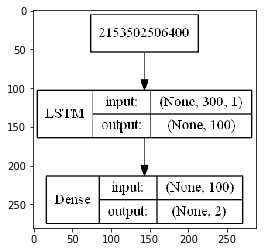

In [28]:
#畫個簡圖
model_img = plt.imread("model.png")
plt.imshow(model_img)

In [29]:
#將1-hot encoding的類別資料轉回原本的類別
#第一種方法
def re1hot(c):
    length = len(c)
    for i in range(length):
        if c[i]!=0:
            c = np.int(i)
            if c == 0:
                return("Gossiping")
            else:
                return("Statistics")
#第二種方法
index = np.argwhere(y_test == 1 )
#print(index)
print(index[:,1])
y_test_raw = index[:,1]

[0 0 0 ... 0 1 0]


In [30]:
#將測試集的數字序列轉回文字
mapped_int = []
pbar2 = pyprind.ProgBar(8038,
                       title='Map ints to reviews')
X_test =X_test.reshape(len(X_test),300)
X_test_list = list(X_test)
for article in X_test_list:
    mapped_int.append([int_to_word[word] for word in article if word != 0])
    pbar2.update()

Map ints to reviews
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


In [31]:
print(mapped_int[6666])

['\r\n', '小弟', '身為', '城市', '觀察家', '遊民', '自居', '\r\n', '\r\n', '發現', '市容', '主要', '的', '問題', '不是', '鐵窗', '\r\n', '\r\n', '而是', '陽台', '或是', '冷氣機', '\r\n', '\r\n', '早期', '的', '房子', '一律', '規劃', '有陽台', '\r\n', '\r\n', '但', '事實', '實用', '度', '偏低', '而且', '有陽台', '感覺', '比較', '好', '入侵', '\r\n', '\r\n', '較', '沒有', '安全感', '\r\n', '\r\n', '導致', '每戶', '都', '想法', '不同', '有人', '裝', '鐵窗', '有人', '外', '推', '\r\n', '\r\n', '反而', '原本', '沒有', '裝', '鐵窗', '的', '人', '反而', '格格不入', '\r\n', '\r\n', '後來', '看', '一些', '房子', '拉皮', ',', '\r\n', '\r\n', '就是', '一律', '把陽台', '拿掉', ',', '統一', '裝', '上', '窗戶', '\r\n', '\r\n', '然後', '用個', '鐵板', '啥', '的', '一起', '蓋住', '冷氣機', '\r\n', '\r\n', '早期', '設置', '的', '冷', '氣孔', ',', '也', '沒', '設想', '到', '分離式', '的', '問題', '\r\n', '\r\n', '最後', '拉完', '皮', '也', '就', '普普通通', '，', '沒', '特別', '好看', '，', '但', '至少', '統一', '\r\n', '\r\n', '有沒有', '古代人', '堅持', '要', '做陽台', '的', '的', '八卦', '\r\n', '\r\n', '謝謝', '\r\n', '\r\n']


## G2.混淆矩陣

In [32]:
def plot_confusion_matrix(confusion_matrix, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots(figsize=(20, 10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()
#機器學習概論的助教提供的function

Confusion matrix, without normalization


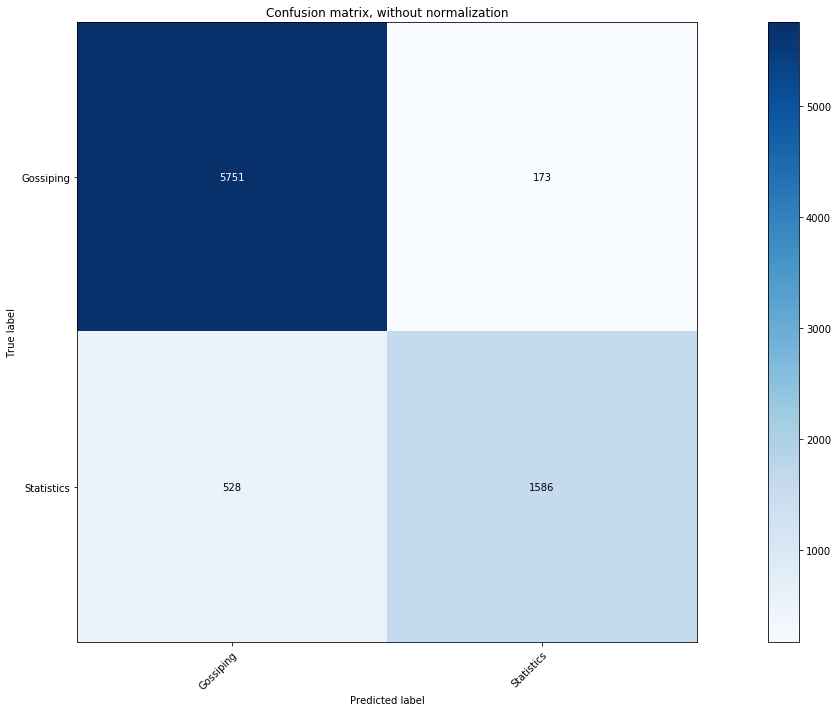

8038/8038 [==============================] - 43s 5ms/step
Accuracy: [0.23278720655023652, 0.9127892510426463]
              precision    recall  f1-score   support

   Gossiping       0.92      0.97      0.94      5924
  Statistics       0.90      0.75      0.82      2114

   micro avg       0.91      0.91      0.91      8038
   macro avg       0.91      0.86      0.88      8038
weighted avg       0.91      0.91      0.91      8038



In [34]:
X_train =X_train.reshape(len(X_train),300,1)
X_test =X_test.reshape(len(X_test),300,1)

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

y_pred = model.predict_classes(X_test)

cmrnn = confusion_matrix(y_test_raw, y_pred)
classes = ['Gossiping', 'Statistics']

plot_confusion_matrix(cmrnn,classes)
print('Accuracy:', model.evaluate(X_test,y_test))
print(classification_report(y_test_raw, y_pred, target_names=classes))

# H.看看電腦的判斷吧！

In [35]:
rd = np.random.randint(8038)
print("文章內容：",mapped_int[rd],"\n")
print("真實類別：",re1hot(y_test[rd]))

if y_pred[rd] == 0:
    y_pred_class = "Gossiping"
else:
    y_pred_class = "Statistics"
print("預測類別：",y_pred_class,"\n")

文章內容： ['\r\n', '我', '不是', '本科', '系', '的', '，', '在', '某篇', 'paper', '上', '看到', '這個', '方法', '，', '但', '不', '知道', '是', '幹什麼', '用', '的', '\r\n', '\r\n', '不', '知道', '板上', '有沒有', '人能', '簡單', '的', '用', '幾句話', '幫', '我', '介紹', '一下', '這是', '什麼', '東西', '呢', '？', '\r\n', '\r\n', '比如說', '什麼', '情況', '下', '，', '用', '一般', '的', '什麼', '統計方法', '，', '會', '有', '什麼', '問題', '\r\n', '\r\n', '而', '這個', '方法', '是', '用來', '解決', '什麼', '問題', '，', '有時候', '會', '不會', '衍生', '出些', '什麼', '問題', '等等', '\r\n', '\r\n', '已經', '估過', '，', '但', '沒有', '這麼', '精闢', '的', '解釋', '，', '太', '艱深', '的', '我', '都', '看不懂', 'orz', '\r\n', '\r\n', '小弟', '在', '這裡', '先', '謝過', '了', '<', '(', '_', '_', ')', '>', '\r\n', '\r\n', '-', '-', '\r\n', '\r\n'] 

真實類別： Statistics
預測類別： Statistics 



In [36]:
from ipywidgets import interact_manual#互動的套件

In [37]:
predict = model.predict_classes(X_test)

In [38]:
def test(idx):
    print("文章內容：",mapped_int[idx],"\n")
    print("神經網路判斷為：",re1hot(y_test[idx]))
    if predict[idx] == 0:
        y_pred_class = "Gossiping"
    else:
        y_pred_class = "Statistics"
    print("預測類別：",y_pred_class,"\n")

In [39]:
interact_manual(test,idx=(0,8037))

interactive(children=(IntSlider(value=4018, description='idx', max=8037), Button(description='Run Interact', s…

<function __main__.test(idx)>